<center><h1><b>Proyek Analisis Sentimen</b></h1></center>
<center><h2><b>Sentimen Review Sociolla</b></h2></center>
<center><h3><b>Created by: Lis Wahyuni</b></h3></center>

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, SpatialDropout1D, MaxPooling1D, Embedding, LSTM, Dense, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
import re
from sklearn.utils import resample
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [2]:
# Load data
df = pd.read_csv('sociolla_reviews.csv')
df.head(3)

,product_url,rating,review,scraped_at
0,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,4.8,"udah mau dua minggu pake, honestly aku ngerasa ini bagus banget. sempet bingung antara yg blue moon sama yang ini tapi condong ke dia dari awal beli. teksturnya ga terlalu tebel, tp pakenya jgn terlalu banyak kalo kalian tipe muka berminyak. jadi lembab banget, cocok!",2025-01-29 14:16:01
1,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,4.8,"Sudah hampir 2 bulan pakai ini. Claim nya melembabkan kulit wajah dan diperuntukan bagi dry skin. Yang aku rasakan efeknya memang cukup melembabkan. Aku pakai di malam hari, ketika bangun tidur wajah terasa moist, tapi gak sampe berminyak banget. Selain itu aku merasa kulit wajah keliatan agak lebih glowing. Alhamdulilah gak ada keluhan aneh-aneh untuk kulit sensitif ini. So far aku suka, tapi mau ganti moisturizer karena mau coba yang lain bukan karna gak cocok. Hehehe",2025-01-29 14:16:01
2,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,5.0,"awalnya beli produk ini karena emang mau nyari moisturizer trus pas dateng suka banget sm packagingnya ada spatula trus lucu aja gitu dan ternyata cocok, kulitku jadi lebih halus padahal kulitku kombinasi cenderung berminyak gitu tapi ini ga bikin berminyak sih di aku dan paling penting ga bikin jerawatan atau bruntusan so far aku sangat sukaa",2025-01-29 14:16:01


In [28]:
# Check the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13900 entries, 0 to 11228
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_url       13900 non-null  object 
 1   rating            13900 non-null  float64
 2   review            13900 non-null  object 
 3   scraped_at        13900 non-null  object 
 4   sentiment         13900 non-null  object 
 5   processed_review  13900 non-null  object 
dtypes: float64(1), object(5)
memory usage: 760.2+ KB


In [3]:
# Check for duplicates
df.duplicated(subset=['product_url', 'rating', 'review']).sum()

0

The dataframe has no missing and duplicate values.

In [4]:
# Set stopwords
stopwords_set = set(stopwords.words("indonesian"))

In [5]:
# Preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(filter(lambda word: word not in stopwords_set, text.split()))
    return text

df['review'] = df['review'].apply(preprocess_text)

In [10]:
def get_sentiment(text):
    # Create TextBlob object
    analysis = TextBlob(text)
    
    # Get polarity score
    polarity = analysis.sentiment.polarity
    
    # Classify sentiment based on polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

#Apply sentiment analysis to the review column
df['sentiment'] = df['review'].apply(get_sentiment)

In [ ]:
# Display distribution of sentiments
df['sentiment'].value_counts()

sentiment
neutral     7172
positive    4809
negative     600
Name: count, dtype: int64

In [13]:
# Display some examples to verify
for index, row in df.head().iterrows():
    print(f"\nReview: {row['review'][:100]}...")
    print(f"Sentiment: {row['sentiment']}")


Review: udah minggu pake honestly ngerasa bagus banget sempet bingung yg blue moon condong beli teksturnya g...
Sentiment: positive

Review: pakai claim nya melembabkan kulit wajah diperuntukan dry skin rasakan efeknya melembabkan pakai mala...
Sentiment: positive

Review: beli produk emang nyari moisturizer trus pas dateng suka banget sm packagingnya spatula trus lucu aj...
Sentiment: positive

Review: if you have dry skin i recommend you to use this product oily makenya tipis aja udah melembapkan ban...
Sentiment: negative

Review: pake gak ngelembabin muka ku banget rada gitu enak sih wanginya tp gak mengganggu wanginya bikin muk...
Sentiment: neutral


In [15]:
# Down sampling positive data
df_positive = df[df['sentiment'] == 'positive']
df_negative = df[df['sentiment'] == 'negative']
df_neutral  = df[df['sentiment'] == 'neutral']

undersampling_neutral_count = abs(10_000 - (df_positive.shape[0] + df_negative.shape[0] + df_neutral.shape[0]))
undersampling_neutral_count = df_neutral.shape[0] - undersampling_neutral_count
print("Total Undersampling Neutral: ", undersampling_neutral_count)
df_neutral = df_neutral.sample(undersampling_neutral_count)

Total Undersampling Neutral:  4591


In [16]:
df = pd.concat([df_positive, df_negative, df_neutral], axis=0)
df['sentiment'].value_counts()

sentiment
positive    4809
neutral     4591
negative     600
Name: count, dtype: int64

In [19]:
# Upsample negative class
df_negative_upsampled = resample(df_negative, 
                                replace=True,
                                n_samples=4500,
                                random_state=42)

# Combine all the data back together
df = pd.concat([df_positive, df_neutral, df_negative_upsampled])
df['sentiment'].value_counts()

sentiment
positive    4809
neutral     4591
negative    4500
Name: count, dtype: int64

In [20]:
df['processed_review'] = df['review'].copy()

In [25]:
# Check length sequences
df['processed_review'].apply(lambda sent: len(sent.split())).describe()

count    13900.000000
mean        27.732086
std         15.853283
min          0.000000
25%         18.000000
50%         23.000000
75%         32.000000
max        340.000000
Name: processed_review, dtype: float64

In [29]:
# Create empty DataFrame to store word frequencies
word_freq_df = pd.DataFrame()

# Get word frequencies for each sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    # Get all reviews for this sentiment
    reviews = df[df['sentiment'] == sentiment]['processed_review']
    
    # Count word frequencies
    word_counts = pd.Series(' '.join(reviews.astype(str)).lower().split()).value_counts()
    
    # Add to DataFrame
    word_freq_df[f'{sentiment}_freq'] = word_counts

# Fill NaN values with 0
word_freq_df = word_freq_df.fillna(0)

# Add total frequency column
word_freq_df['total'] = word_freq_df.sum(axis=1)

# Sort by total frequency
word_freq_df = word_freq_df.sort_values('total', ascending=False)

# Reset index to make word column
word_freq_df = word_freq_df.reset_index().rename(columns={'index': 'word'})

# Display first few rows to verify
print("\nWord frequencies across sentiments:")
print(word_freq_df.head(30))


Word frequencies across sentiments:
          word  positive_freq  neutral_freq  negative_freq   total
0        kulit           2893        2574.0         2528.0  7995.0
1       banget           3115        2530.0         2304.0  7949.0
2        toner           3220        2440.0         1999.0  7659.0
3           ga           2160        1844.0         2050.0  6054.0
4        bikin           1838        1644.0         1781.0  5263.0
5         pake           1806        1697.0         1501.0  5004.0
6           yg           1893        1374.0         1686.0  4953.0
7        cocok           1343        1455.0         1588.0  4386.0
8          nya           1385        1142.0         1446.0  3973.0
9          sih           1325        1016.0         1100.0  3441.0
10         gak           1109        1032.0         1265.0  3406.0
11        muka           1163        1196.0          951.0  3310.0
12       bagus            919        1153.0         1143.0  3215.0
13        suka           

In [30]:
', '.join(word_freq_df['word'].to_list())

'kulit, banget, toner, ga, bikin, pake, yg, cocok, nya, sih, gak, muka, bagus, suka, teksturnya, produk, pakai, bgt, aja, skin, gitu, udah, pas, kalo, beli, sunscreen, kering, wajah, enak, jerawat, lembab, bener, it, lumayan, ringan, ya, the, karna, coba, dipake, melembabkan, tp, thick, berminyak, efek, lengket, to, kulitku, oily, and, so, i, gampang, cepet, tekstur, kali, cair, my, this, repurchase, jd, langsung, moisturizer, ku, pemakaian, meresap, worth, harganya, dry, oke, make, sensitif, harga, kayak, aman, emang, hydrating, product, mudah, dipakai, makeup, cepat, skincare, for, up, nggak, benton, bha, a, base, ngga, deh, abis, essence, super, kaya, hasilnya, berasa, menyerap, packaging, but, botol, packagingnya, si, tuh, nyaman, acne, menurutku, gel, kental, exfo, is, texture, jg, kandungan, moist, bruntusan, love, exfoliating, far, udh, kulitnya, glowing, murah, produknya, keliatan, habis, wanginya, krn, baunya, tonernya, texturenya, kerasa, no, isinya, whitecast, sampe, aloe, s

In [31]:
words_to_remove = word_freq_df['word'].head(100).tolist()

In [32]:
negative_words = [
    # Skin problems
    'jerawat', 'iritasi', 'gatal', 'breakout', 'bintik', 'bruntusan', 'komedo', 'kusam', 'berminyak',
    'merah', 'perih', 'panas', 'kemerahan', 'berjerawat', 'beruntusan', 'berkomedo', 'noda', 'flek',
    
    # Product issues
    'lengket', 'mengelupas', 'berminyak', 'kering', 'kasar', 'berat', 'tebal', 'keras',
    'whitecast', 'putih', 'pilling', 'menggumpal', 'mengkilap', 'berminyak',
    
    # Negative reactions
    'alergi', 'sensitif', 'reaksi', 'ruam', 'bengkak', 'memerah', 'kusam', 'gelap',
    
    # Negative sentiments
    'kecewa', 'nyesel', 'buruk', 'mahal', 'mengecewakan', 'buang', 'rugi', 'zonk', 'gagal',
    'jelek', 'parah', 'sia', 'buang', 'boros', 'susah', 'aneh', 'kurang', 'tidak', 'enggak',
    'males', 'bete', 'benci', 'jangan', 'hindari', 'skip', 'stop',
    
    # Performance issues
    'lambat', 'lama', 'memburuk', 'memperburuk', 'membekas', 'menghitam', 'menumpuk',
    'percuma', 'sia', 'buang', 'habis', 'cepet', 'boros', 'banyak', 'sedikit',
    
    # Negative intensifiers
    'sangat', 'banget', 'terlalu', 'super', 'parah', 'sekali'
]

In [33]:
def clean_text(text, sentiment):
    # Get preprocessed words
    words = text.split()
    
    if sentiment == 'positive':
        # For positive reviews, remove positive words unless they're part of negative context
        words = [word for word in words if (word not in words_to_remove) or (word not in negative_words)]
    elif sentiment == 'neutral':
        # For neutral reviews, keep all words but emphasize negative ones
        words = [word for word in words if word not in words_to_remove]
    # For negative reviews, keep all words as is
    
    return ' '.join(words)

# Apply to DataFrame
df['processed_review'] = df.apply(lambda x: clean_text(x['processed_review'], x['sentiment']), axis=1)

In [34]:
df.head()

,product_url,rating,review,scraped_at,sentiment,processed_review
0,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,4.8,udah minggu pake honestly ngerasa bagus banget sempet bingung yg blue moon condong beli teksturnya ga tebel tp pakenya jgn kalo tipe muka berminyak lembab banget cocok,2025-01-29 14:16:01,positive,udah minggu pake honestly ngerasa bagus sempet bingung yg blue moon condong beli teksturnya ga tebel tp pakenya jgn kalo tipe muka lembab cocok
1,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,4.8,pakai claim nya melembabkan kulit wajah diperuntukan dry skin rasakan efeknya melembabkan pakai malam bangun tidur wajah moist gak sampe berminyak banget kulit wajah keliatan glowing alhamdulilah gak keluhan anehaneh kulit sensitif so far suka ganti moisturizer coba karna gak cocok hehehe,2025-01-29 14:16:01,positive,pakai claim nya melembabkan kulit wajah diperuntukan dry skin rasakan efeknya melembabkan pakai malam bangun tidur wajah moist gak sampe kulit wajah keliatan glowing alhamdulilah gak keluhan anehaneh kulit so far suka ganti moisturizer coba karna gak cocok hehehe
2,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,5.0,beli produk emang nyari moisturizer trus pas dateng suka banget sm packagingnya spatula trus lucu aja gitu cocok kulitku halus kulitku kombinasi cenderung berminyak gitu ga bikin berminyak sih ga bikin jerawatan bruntusan so far sukaa,2025-01-29 14:16:01,positive,beli produk emang nyari moisturizer trus pas dateng suka sm packagingnya spatula trus lucu aja gitu cocok kulitku halus kulitku kombinasi cenderung gitu ga bikin sih ga bikin jerawatan bruntusan so far sukaa
8,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,3.8,kulitku yg super berminyak teksturny lumayan pekat jd mesti pake tipis banget biasany pake utk ngseal skin care malem kalo pake exfo serumtoner paginy lumayan lembab gak bikin kering dgn hargany sbnerny worth it ngefek tp krna tekstur trlalu thick jd bikin rawan over hidrasi kulitku and yess suka packaging yg pake karton daur ulang,2025-01-29 14:16:24,positive,kulitku yg teksturny lumayan pekat jd mesti pake tipis biasany pake utk ngseal skin care malem kalo pake exfo serumtoner paginy lumayan lembab gak bikin dgn hargany sbnerny worth it ngefek tp krna tekstur trlalu thick jd bikin rawan over hidrasi kulitku and yess suka packaging yg pake karton daur ulang
11,https://www.sociolla.com/face-cream-lotion/16544-sky-rose-moisturizer,5.0,nyoba produk mois nya jenis gtu yg satunya mengndung alkohol pilih non alkohol semoga aja cocok review kelanjutannya pake thanks,2025-01-29 14:16:24,positive,nyoba produk mois nya jenis gtu yg satunya mengndung alkohol pilih non alkohol semoga aja cocok review kelanjutannya pake thanks


In [35]:
# Preview length of reviews
df['processed_review'].apply(lambda sent: len(sent.split())).describe()

count    13900.000000
mean        23.599568
std         16.877302
min          0.000000
25%         13.000000
50%         20.000000
75%         29.000000
max        340.000000
Name: processed_review, dtype: float64

In [49]:
# Define constants first
MAX_LENGTH = 23
VOCAB_SIZE = 13_900

# Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')

# Choose one column for processing (either 'cleaned_review' or 'processed_review')
# Here we'll use 'cleaned_review' as it seems to be the final version
tokenizer.fit_on_texts(df['processed_review'])

# Create sequences and pad them
sequences = tokenizer.texts_to_sequences(df['processed_review'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [50]:
# Split data
X = padded_sequences
y = df['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [51]:
df.shape

(13900, 6)

In [52]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (11120, 23)
y_train: (11120,)
X_val: (1390, 23)
y_val: (1390,)
X_test: (1390, 23)
y_test: (1390,)


In [57]:
# Define unified training function
def train_model_unified(model_type, X_train, X_val, y_train, y_val, vocab_size, max_len=MAX_LENGTH):

    class_weights = compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train
    )
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))
    print("Class Weight (Balance): ", class_weight_dict)
    
    # Convert labels to categorical
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    
    y_train_cat = tf.keras.utils.to_categorical(y_train_encoded)
    y_val_cat = tf.keras.utils.to_categorical(y_val_encoded)
    
    # Create model based on type
    if model_type == 'lstm':
        model = create_lstm_model(vocab_size, max_len=max_len)
    elif model_type == 'cnn':
        model = create_cnn_model(vocab_size, max_len=max_len)
    elif model_type == 'gru':
        model = create_gru_model(vocab_size, max_len=max_len)

    # Preview model architecture
    print(model.summary())
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )
    
    history = model.fit(
        X_train, y_train_cat,
        epochs=10,
        batch_size=16,
        validation_data=(X_val, y_val_cat),
        class_weight=class_weight_dict,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return model, le, history

# Define model architectures of LSTM
def create_lstm_model(vocab_size, embedding_dim=64, max_len=100):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(16, dropout=0.1, return_sequences=True),
        GlobalMaxPooling1D(),
        Dense(3, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy', 
        optimizer="adam",
        metrics=['accuracy']
    )
    return model

# Define model architectures of CNN
def create_cnn_model(vocab_size, embedding_dim=300, max_len=300):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        SpatialDropout1D(0.2),
        Conv1D(512, 5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(512, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(learning_rate=0.0001),
                 metrics=['accuracy'])
    return model

# Define model architectures of GRU
def create_gru_model(vocab_size, embedding_dim=300, max_len=300):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        SpatialDropout1D(0.2),
        Bidirectional(GRU(512, return_sequences=True)),
        Bidirectional(GRU(256)),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(learning_rate=0.0001),
                 metrics=['accuracy'])
    return model

In [58]:
# Train all models
vocab_size = len(tokenizer.word_index) + 1
print("Total Vocab Size:", vocab_size)

Total Vocab Size: 15699


In [59]:
# Train LSTM
model1, le1, history1 = train_model_unified('lstm', X_train, X_val, y_train, y_val, vocab_size=15_000)

Class Weight (Balance):  {'negative': 1.023093200846444, 'neutral': 1.011092925986543, 'positive': 0.9675454624554076}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7219 - loss: 0.6347 - val_accuracy: 0.9669 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 2/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9808 - loss: 0.0765 - val_accuracy: 0.9914 - val_loss: 0.0442 - learning_rate: 0.0010
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9973 - loss: 0.0191 - val_accuracy: 0.9863 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 0.9856 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9998 - loss: 0.0029 - val_accuracy: 0.9856 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9827 - val_loss: 0.0682 - learning_rate: 0.0010
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9996 - loss: 0.00

In [60]:
# Train CNN
model2, le2, history2 = train_model_unified('cnn', X_train, X_val, y_train, y_val, vocab_size=15_000)

Class Weight (Balance):  {'negative': 1.023093200846444, 'neutral': 1.011092925986543, 'positive': 0.9675454624554076}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.6048 - loss: 1.0470 - val_accuracy: 0.8288 - val_loss: 0.4501 - learning_rate: 1.0000e-04
Epoch 2/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.8650 - loss: 0.3541 - val_accuracy: 0.9597 - val_loss: 0.1157 - learning_rate: 1.0000e-04
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9417 - loss: 0.1631 - val_accuracy: 0.9791 - val_loss: 0.0823 - learning_rate: 1.0000e-04
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9624 - loss: 0.1075 - val_accuracy: 0.9791 - val_loss: 0.0905 - learning_rate: 1.0000e-04
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9759 - loss: 0.0705 - val_accuracy: 0.9842 - val_loss: 0.0749 - learning_rate: 1.0000e-04
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.9797 - loss: 0.0632 - val_accuracy: 0.9856 - val_loss: 0.0734 - learning_rate: 1.0000e-04
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 34s 49m

In [61]:
# Train GRU
model3, le3, history3 = train_model_unified('gru', X_train, X_val, y_train, y_val, vocab_size=15_000)

Class Weight (Balance):  {'negative': 1.023093200846444, 'neutral': 1.011092925986543, 'positive': 0.9675454624554076}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 106s 148ms/step - accuracy: 0.6159 - loss: 0.9121 - val_accuracy: 0.9439 - val_loss: 0.1663 - learning_rate: 1.0000e-04
Epoch 2/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 116s 167ms/step - accuracy: 0.9264 - loss: 0.2057 - val_accuracy: 0.9748 - val_loss: 0.0823 - learning_rate: 1.0000e-04
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 113s 162ms/step - accuracy: 0.9679 - loss: 0.0921 - val_accuracy: 0.9806 - val_loss: 0.0631 - learning_rate: 1.0000e-04
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 111s 160ms/step - accuracy: 0.9841 - loss: 0.0454 - val_accuracy: 0.9885 - val_loss: 0.0494 - learning_rate: 1.0000e-04
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 112s 161ms/step - accuracy: 0.9919 - loss: 0.0285 - val_accuracy: 0.9820 - val_loss: 0.1080 - learning_rate: 1.0000e-04
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 111s 160ms/step - accuracy: 0.9898 - loss: 0.0290 - val_accuracy: 0.9871 - val_loss: 0.0584 - learning_rate: 1.0000e-04
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━

In [62]:
# Evaluate models
def evaluate_model(model, X_test, y_test, le):

    # Predict
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_encoded = le.transform(y_test)
    
    # Calculate and display classification report with focus on recall
    print("\nClassification Report (focus on recall):")
    print(classification_report(y_test_encoded, y_pred_classes, 
                              target_names=['negative', 'neutral', 'positive'],
                              zero_division=0))
    
    # Create confusion matrix with recall values
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    recall_values = np.diag(cm) / np.sum(cm, axis=1)
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot recall per class
    plt.figure(figsize=(8,6))
    sns.barplot(x=['negative', 'neutral', 'positive'], 
                y=recall_values)
    plt.title('Recall Score per Class')
    plt.ylabel('Recall Score')
    plt.xlabel('Sentiment Class')
    plt.ylim(0, 1)
    for i, v in enumerate(recall_values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
    plt.show()
    
    # Print recall scores
    print("\nRecall Scores per Class:")
    for class_name, recall in zip(['Negative', 'Neutral', 'Positive'], recall_values):
        print(f"{class_name}: {recall:.3f}")

    # Preview miss classified sample data
    miss_classified_idx = y_pred_classes != y_test_encoded
    miss_classified_texts = X_test[miss_classified_idx]
    actual_labels = y_test[miss_classified_idx]
    predicted_labels = le.inverse_transform(y_pred_classes[miss_classified_idx])
    print("\nMiss Classified Samples:")
    print("-" * 100)
    for i in range(min(20, len(miss_classified_texts))):
        print(f"Text: {tokenizer.sequences_to_texts([miss_classified_texts[i]])}")
        print(f"Actual Label: {actual_labels.iloc[i]}")
        print(f"Predicted Label: {predicted_labels[i]}")
        print("-" * 100)


Evaluating BiLSTM Model:
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report (focus on recall):
              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       426
     neutral       1.00      0.99      1.00       466
    positive       0.99      0.99      0.99       498

    accuracy                           0.99      1390
   macro avg       0.99      0.99      0.99      1390
weighted avg       0.99      0.99      0.99      1390



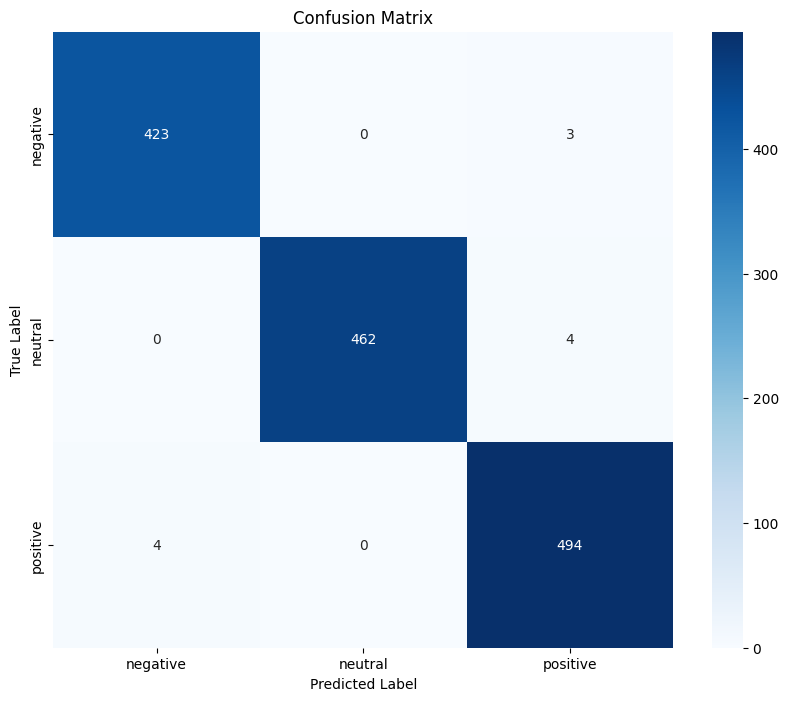

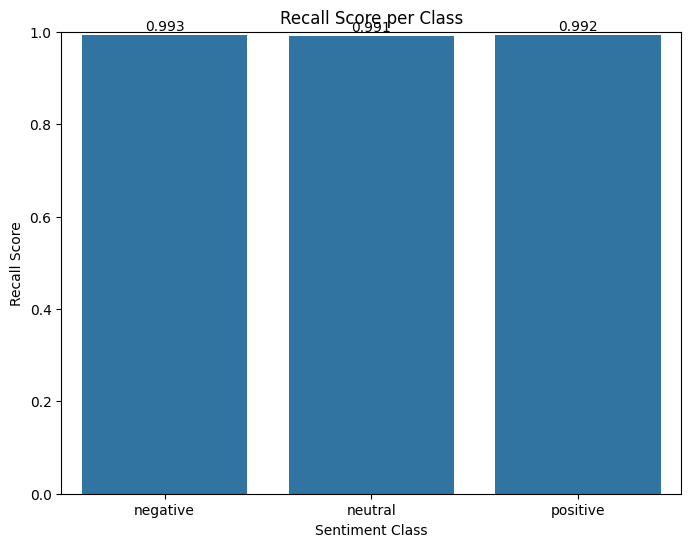


Recall Scores per Class:
Negative: 0.993
Neutral: 0.991
Positive: 0.992

Miss Classified Samples:
----------------------------------------------------------------------------------------------------
Text: ['rentan beruntus titik maksimal itupun hilang ambil pusing breakout dahiku bersih beruntus seneng ketemu kondisi beruntus dateng periode munculnya titik hilang selesai periode']
Actual Label: neutral
Predicted Label: positive
----------------------------------------------------------------------------------------------------
Text: ['sunscreen teraman pake barengan ponakan ku tekstur nya thick sih effort dikit blend nya ga whitecast nya finishnya lembab <OOV> <OOV> <OOV> <OOV>']
Actual Label: positive
Predicted Label: negative
----------------------------------------------------------------------------------------------------
Text: ['kayak yg essence toner cuman bentukannya spray bener kayak air suka spray nya efektif essence toner cocok yg oily skin yg nggak moisture']
Actual Label:

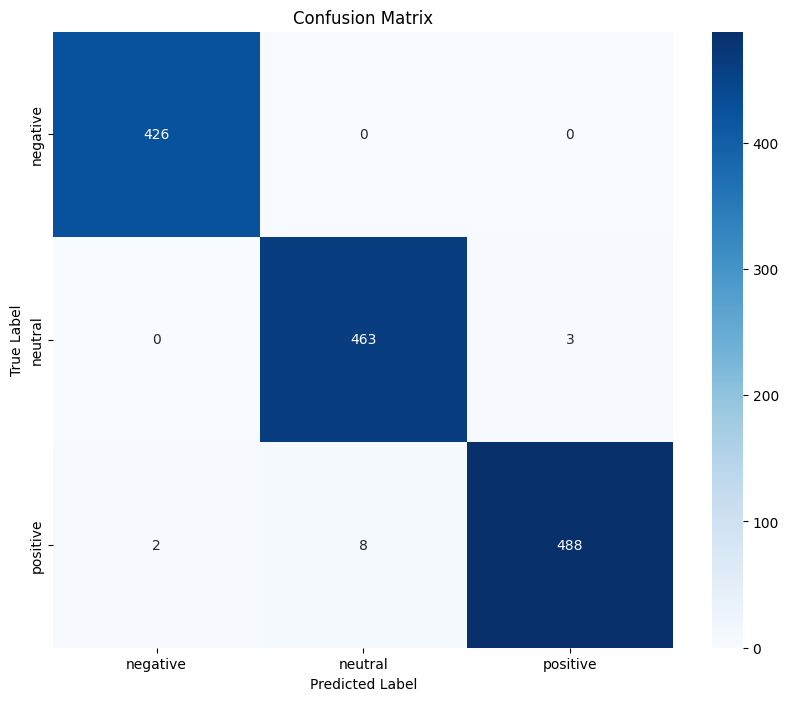

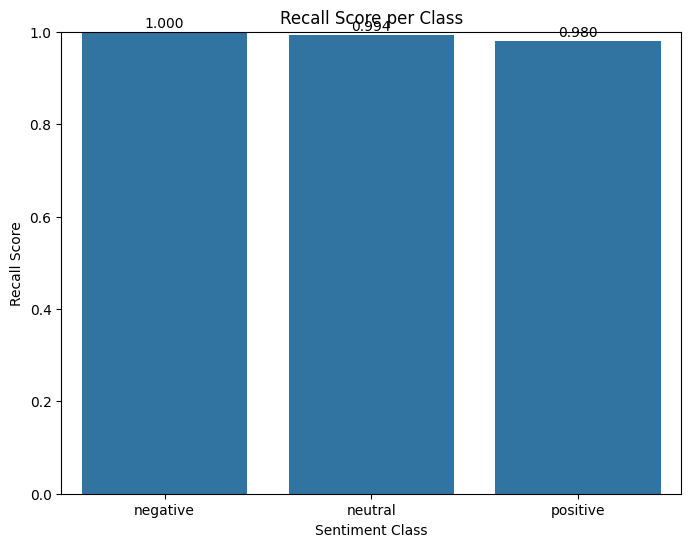


Recall Scores per Class:
Negative: 1.000
Neutral: 0.994
Positive: 0.980

Miss Classified Samples:
----------------------------------------------------------------------------------------------------
Text: ['teksturenya watery warna kuning packingnya flip tumpah tumpah lbh ngeluarin prduknya belom ngaruh kupake sehabis fw ngangkat sisa kotoran <OOV> <OOV> <OOV> <OOV>']
Actual Label: neutral
Predicted Label: positive
----------------------------------------------------------------------------------------------------
Text: ['moisturizer kebangaan moisturizer sangatvlife changing sekalii ngebuat bruntusan muka ku pudar sih love <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
Actual Label: positive
Predicted Label: neutral
----------------------------------------------------------------------------------------------------
Text: ['bagussss sekalii yg tadinys kek kebun skrng tandah gandus alias tinggal bekas ny aja yeyyyyy thank youu pyunkangg muachhhh i love you <OOV>']
Actual

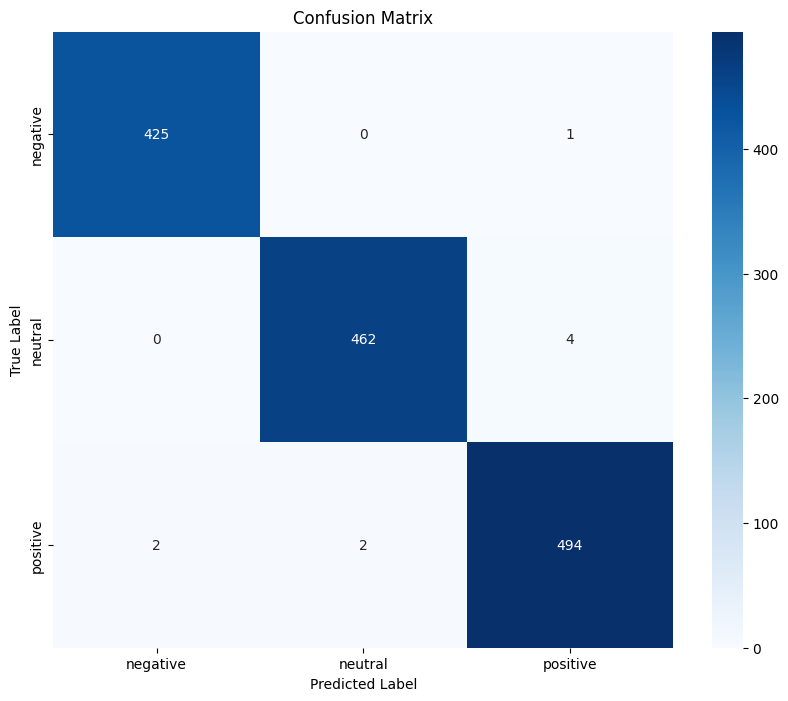

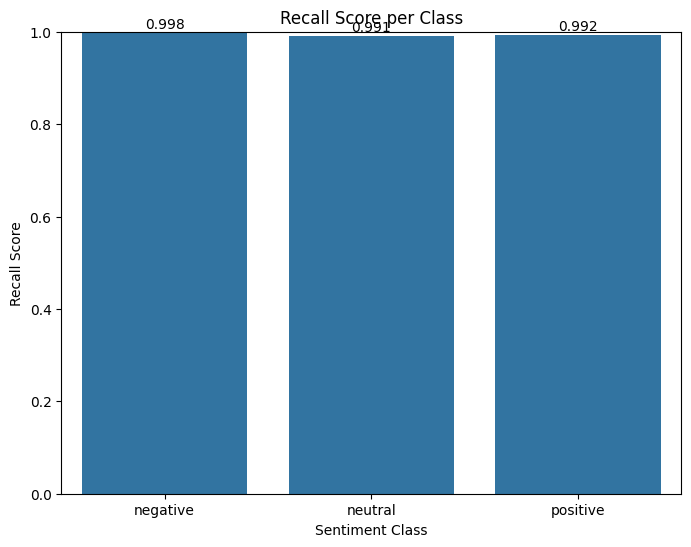


Recall Scores per Class:
Negative: 0.998
Neutral: 0.991
Positive: 0.992

Miss Classified Samples:
----------------------------------------------------------------------------------------------------
Text: ['rentan beruntus titik maksimal itupun hilang ambil pusing breakout dahiku bersih beruntus seneng ketemu kondisi beruntus dateng periode munculnya titik hilang selesai periode']
Actual Label: neutral
Predicted Label: positive
----------------------------------------------------------------------------------------------------
Text: ['sunscreen teraman pake barengan ponakan ku tekstur nya thick sih effort dikit blend nya ga whitecast nya finishnya lembab <OOV> <OOV> <OOV> <OOV>']
Actual Label: positive
Predicted Label: negative
----------------------------------------------------------------------------------------------------
Text: ['daily ngga narik lbh moisturizing bngt krn kandungan aloe vera lbh kyk essence nya pyun kang yul membantu ngurangin minyak berlebih dimuka mencegah']
Ac

In [63]:
# Evaluate each model
models = {
    'BiLSTM': model1, 
    'CNN': model2, 
    'GRU': model3
}
for name, model in models.items():
    print(f"\nEvaluating {name} Model:")
    evaluate_model(model, X_test, y_test, le1)  # Using le1 as they should be equivalent
    print("---" * 50)

In [64]:
# Save the model and necessary components
model3.save('best_model.h5')
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)
with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(le1, handle)
    

print("Model saved as 'best_model.h5'")
print("Tokenizer saved as 'tokenizer.pkl'")
print("Label encoder saved as 'label_encoder.pkl'")

Model saved as 'best_model.h5'
Tokenizer saved as 'tokenizer.pkl'
Label encoder saved as 'label_encoder.pkl'
